In [5]:
# here are some set up code to ignore 
import numpy as np
import pickle
import scipy
from sklearn import linear_model, datasets, neighbors, metrics
from sklearn.cross_validation import train_test_split
from scipy.linalg import block_diag



%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [15]:
# Constants 

# I pulled activations of 8 layers. Here is the index ref to the layers
LAYERS = {'pool1': 0, 'pool2': 1, 'pool3': 2, 'pool4': 3,
          'pool5': 4, 'fc6': 5, 'fc7': 6} # 'prob': 7} taking out probability layer for now. 

LAYERS_NM = ['pool1', 'pool2', 'pool3', 'pool4', 'pool5', 'fc6', 'fc7']
# constants for the images

FURNITURES = ['bed', 'bench', 'chair', 'table']

VGG_SIZE_X = 224
VGG_SIZE_Y = 224
VGG_SIZE_Z = 3

# constants for train/test for the linear discriminability
TRAIN_SZ = 0.80
TEST_SZ = 1 - TRAIN_SZ


In [7]:
# pulling/cleaning up the data

# downloading the activations. I had to split the sample (each act has 160 images) because they're about 3GB each. 
full_act = []
for num_act in xrange(0,11):
    filename = 'sketch_act/sketch_act' + str(num_act) + '.p'
    full_act.append(pickle.load(open(filename, 'rb')))


In [8]:
# downloading the targets

target = pickle.load(open('target.p', 'rb'))

In [9]:
def restackFCAct(act, layer_nm):
    layer_act = np.vstack((np.asarray(act[0][LAYERS[layer_nm]]), 
                           np.asarray(act[1][LAYERS[layer_nm]]),
                          np.asarray(act[2][LAYERS[layer_nm]]),
                          np.asarray(act[3][LAYERS[layer_nm]]),
                          np.asarray(act[4][LAYERS[layer_nm]]),
                          np.asarray(act[5][LAYERS[layer_nm]]),
                          np.asarray(act[6][LAYERS[layer_nm]]),
                          np.asarray(act[7][LAYERS[layer_nm]]),
                          np.asarray(act[8][LAYERS[layer_nm]]),
                          np.asarray(act[9][LAYERS[layer_nm]]),
                          np.asarray(act[10][LAYERS[layer_nm]])))
    return layer_act


def restackPoolAct(act, layer_nm):
    x_size = np.asarray(act[0][LAYERS[layer_nm]]).shape[0]
    y_size = np.asarray(act[0][LAYERS[layer_nm]]).shape[1] * np.asarray(act[0][LAYERS[layer_nm]]).shape[2] * np.asarray(act[0][LAYERS[layer_nm]]).shape[3] 
    layer_act = np.vstack((np.asarray(act[0][LAYERS[layer_nm]]).reshape(x_size, y_size), 
                           np.asarray(act[1][LAYERS[layer_nm]]).reshape(x_size, y_size),
                          np.asarray(act[2][LAYERS[layer_nm]]).reshape(x_size, y_size),
                          np.asarray(act[3][LAYERS[layer_nm]]).reshape(x_size, y_size),
                          np.asarray(act[4][LAYERS[layer_nm]]).reshape(x_size, y_size),
                          np.asarray(act[5][LAYERS[layer_nm]]).reshape(x_size, y_size),
                          np.asarray(act[6][LAYERS[layer_nm]]).reshape(x_size, y_size),
                          np.asarray(act[7][LAYERS[layer_nm]]).reshape(x_size, y_size),
                          np.asarray(act[8][LAYERS[layer_nm]]).reshape(x_size, y_size),
                          np.asarray(act[9][LAYERS[layer_nm]]).reshape(x_size, y_size),
                          np.asarray(act[10][LAYERS[layer_nm]]).reshape(np.asarray(act[10][LAYERS[layer_nm]]).shape[0], y_size)))
    return layer_act

In [10]:
# pulling each layer out of the activation layers
fc6 = restackFCAct(full_act, 'fc6')
fc7 = restackFCAct(full_act, 'fc7')

pool = [] 

for i in xrange(0,5):
    
    pool.append( restackPoolAct(full_act, 'pool' + str(i + 1)))

In [11]:
# sorting the layers accordingly
inds = np.array(target).argsort()
fc6 = fc6[inds,:]
fc7 = fc7[inds,:]
for i in xrange(0,5):
    pool[i] = pool[i][inds,:]


num_views = [target.count('bed'), target.count('bench'), target.count('chair'), target.count('table')]


In [12]:
all_layers = pool
all_layers.append(fc6)
all_layers.append(fc7)

## 1. Representational Similarity Analysis




In [11]:
# getMeanVector gets the mean vector across number of views for num_objects 
# now we can different num_views (so num_views is a vector that dictates the num_views per object)
def getMeanVector(full_batch, num_views, num_objects):
    meanVector = np.empty((num_objects, full_batch.shape[1]), float)
    for i in xrange(0, num_objects):
        # pull out the views of the particular object 
        all_views = full_batch[sum(num_views[:i]) :  sum(num_views[:i]) + num_views[i], :]
        meanVector[i,:] = np.mean(all_views, axis = 0)

    
    return meanVector

In [17]:
RDM_fc7 = np.corrcoef(getMeanVector(fc7, num_views, len(FURNITURES))) 
RDM_fc6 = np.corrcoef(getMeanVector(fc6, num_views, len(FURNITURES))) 

Euc_fc7 = metrics.pairwise.pairwise_distances(getMeanVector(fc7, num_views, len(FURNITURES)), metric='euclidean')
Euc_fc6 = metrics.pairwise.pairwise_distances(getMeanVector(fc6, num_views, len(FURNITURES)), metric='euclidean')


RDM_pool = []
Euc_pool = []
for pool_layer in xrange(0,5):
    RDM_pool_i = np.corrcoef(getMeanVector(pool[pool_layer], num_views, len(FURNITURES)))
    RDM_pool.append(RDM_pool_i)
    Euc_pool_i = metrics.pairwise.pairwise_distances(getMeanVector(pool[pool_layer], num_views, len(FURNITURES)), metric='euclidean')
    Euc_pool.append(Euc_pool_i)

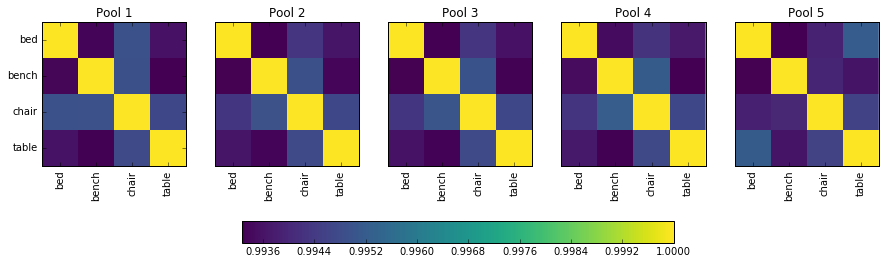

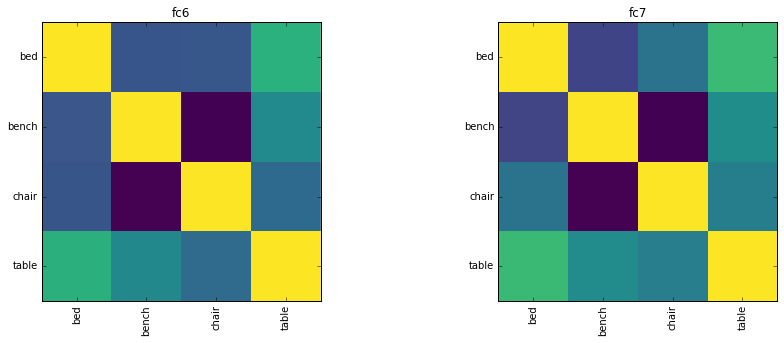

In [13]:
fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')


for pool_layer in xrange(0,5):
    pltname = "Pool " + str(pool_layer + 1)
    plt.subplot(1, 5, pool_layer + 1)
    plt.title(pltname)
    plt.imshow(RDM_pool[pool_layer], cmap = 'viridis', interpolation='none')
    plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')
    
    if pool_layer == 0:
        plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)
    else:
        plt.yticks([])
        
        
fig2 = plt.figure(2,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.imshow(RDM_fc6, cmap = 'viridis', interpolation='none')
plt.title("fc6")
plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')
plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)

plt.subplot(122)
plt.imshow(RDM_fc7,cmap = 'viridis', interpolation='none')
plt.title("fc7")
plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')
plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)

cax = fig.add_axes([0.12, 0.1, 0.78, 0.4])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='horizontal', ax=cax)
plt.show()

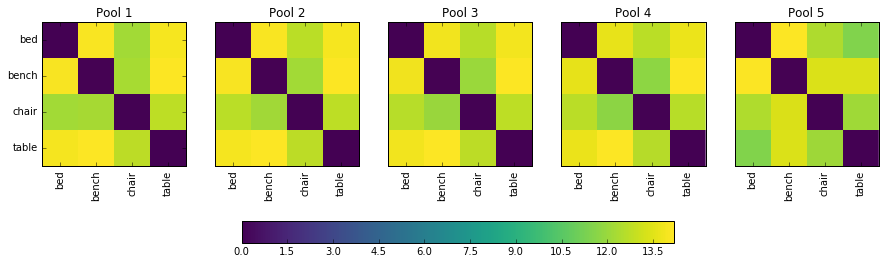

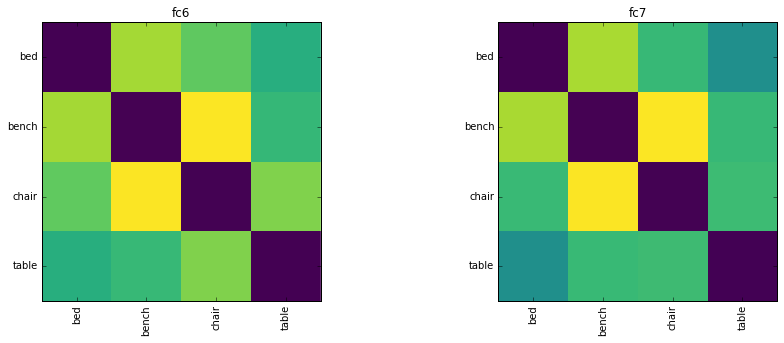

In [18]:
fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')


for pool_layer in xrange(0,5):
    pltname = "Pool " + str(pool_layer + 1)
    plt.subplot(1, 5, pool_layer + 1)
    plt.title(pltname)
    plt.imshow(Euc_pool[pool_layer], cmap = 'viridis', interpolation='none')
    plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')
    
    if pool_layer == 0:
        plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)
    else:
        plt.yticks([])
        
        
fig2 = plt.figure(2,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.imshow(Euc_fc6, cmap = 'viridis', interpolation='none')
plt.title("fc6")
plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')
plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)

plt.subplot(122)
plt.imshow(Euc_fc7,cmap = 'viridis', interpolation='none')
plt.title("fc7")
plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')
plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)

cax = fig.add_axes([0.12, 0.1, 0.78, 0.4])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='horizontal', ax=cax)
plt.show()

## Classifier-based Discriminability

To directly measure object-level discriminability across model layer, we also train a 4-way (& 8-way) logistic regression classifier. We used a 50/50 train/test split within object class. We did not L2-normalize feature vectors prior to training classifier.

However, our imageset was sufficiently clean that even training the model on the first pool layer would lead to a ceiling performance (100% accuracy).  




In [13]:

# full_batch: the full batch of images. I am assuming that the full_batch is arranged as 40 views of obj1, 40 objects of obj2... so forth.  
# train_sz: needs to be a probability, s.t. test_sz = 1 - train-sz. 
def getData(full_batch, num_views, num_objects, test_sz):
    
    num_train = [int(x * (1 - test_sz)) for x in num_views]
    num_test = list(np.array(num_views) - np.array(num_train))
    
    X_train = np.ones((sum(num_train), full_batch.shape[1]), float)
    X_test = np.ones((sum(num_test), full_batch.shape[1]), float)
    
    for i in xrange(0, num_objects):
        X = full_batch[sum(num_views[:i]) :  sum(num_views[:i]) + num_views[i], :]
        
        # randomly shuffle the train/test for the x 
        X_train_i, X_test_i = train_test_split(X, test_size=test_sz)
        X_train[sum(num_train[:i]) :  sum(num_train[:i]) + num_train[i], :] = X_train_i
        X_test[sum(num_test[:i]) :  sum(num_test[:i]) + num_test[i], :] = X_test_i
        
        

    y_train = np.repeat(xrange(0, num_objects), num_train)
    y_test = np.repeat(xrange(0, num_objects), num_test)

    return (X_train, y_train, X_test, y_test)

In [18]:
layer_score = []



for i in xrange(1,len(LAYERS_NM)):
    logreg = linear_model.LogisticRegression()
    X_train, y_train, X_test, y_test = getData(all_layers[i], num_views, len(FURNITURES), TEST_SZ)
    score = logreg.fit(X_train, y_train).score(X_test, y_test)
    print ("Logistic Regression score on layer %s is %f", LAYERS_NM[i], score)
    layer_score.append(score) 


('Logistic Regression score on layer %s is %f', 'pool2', 0.26811594202898553)
('Logistic Regression score on layer %s is %f', 'pool3', 0.33695652173913043)
('Logistic Regression score on layer %s is %f', 'pool4', 0.33333333333333331)
('Logistic Regression score on layer %s is %f', 'pool5', 0.36231884057971014)
('Logistic Regression score on layer %s is %f', 'fc6', 0.33333333333333331)
('Logistic Regression score on layer %s is %f', 'fc7', 0.30434782608695654)


In [ ]:
fig = plt.figure(1,  figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')

plt.title("8-way logistic regression classifier performance on VGG layers ")
plt.plot(np.arange(len(LAYERS_NM) + 1 ), layer_score)
plt.xlabel('Layers')
plt.ylabel('Performance')

x_label = LAYERS_NM
x_label.insert(0, "pixels")

plt.xticks(xrange(0,len(LAYERS) + 1), x_label);
axes = plt.gca()
axes.set_ylim([0.95,1.01]);
vals = axes.get_yticks()
axes.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals]);